In [1]:
import torch
import numpy as np
from utils import prediction,normalization
import time
import matplotlib.pyplot as plt
from thop import profile
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
!pip install onnx

Load the model and data. Then set the inference size, each dimension of the inference size must be divisible by 16, supporting up to 640x640x640 cuboid inference on a 16GB GPU.

In [2]:
model = torch.jit.load('network/FaultNet_Gamma0.7.pt').to(device)
if device.type != 'cpu': model = model.half()
print('parameters_count:',count_parameters(model)/10**6,'MB')

parameters_count: 0.421597 MB


Inference

In [ ]:
data = np.load('data/kerry.npy').transpose((2, 0, 1))
infer_size = data.shape 
print('infer size:',infer_size)
start = time.time()
result = prediction(model, data, device)
end = time.time()
print('1080Ti GPU infer time:',end-start,'s')

infer size: (272, 608, 192)


Show result

In [4]:
def get_result_img (geo_slice, result_slice):
    hm = plt.get_cmap('bone')(geo_slice)[:, :, :-1]
    geo_slice = plt.get_cmap('seismic')(geo_slice)[:, :, :-1]
    logits = np.clip((result_slice[:, :, None]), a_min=0, a_max=1)
    colormap = plt.get_cmap('jet')(logits[:, :, 0])[:, :, :-1]
    hm = np.where(logits > 0.5, colormap, hm)
    return geo_slice, hm

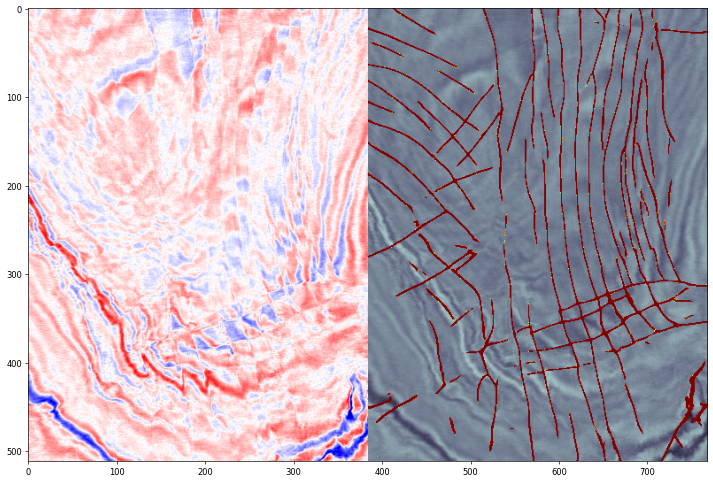

In [5]:
from matplotlib.pyplot import figure

figure(figsize=(15, 10), dpi=60)

data = normalization(data)
tline_slice = data[105,:,:]
iline_slice = data[:,:,16]
xline_slice = data[:,20,:]
tline_result = result[105,:,:]
iline_result = result[:,:,16]
xline_result = result[:,20,:]
tline_slice,tline_result = get_result_img(tline_slice,tline_result)
iline_slice,iline_result = get_result_img(iline_slice,iline_result)
xline_slice,xline_result = get_result_img(xline_slice,xline_result)
tline = np.concatenate((tline_slice,tline_result),1)
iline = np.concatenate((iline_slice,iline_result),1)
xline = np.concatenate((xline_slice,xline_result),1)
plt.imshow(tline)

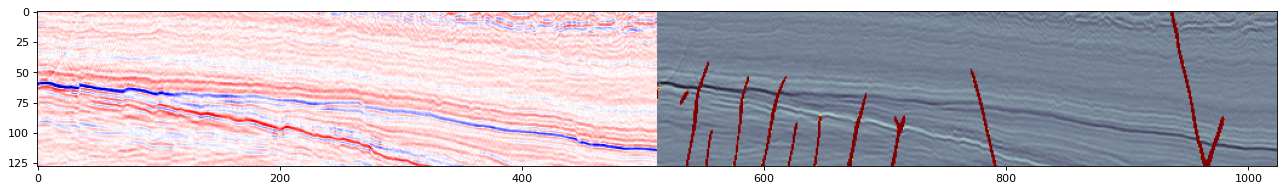

In [6]:
from matplotlib.pyplot import figure

figure(figsize=(20, 13), dpi=80)
plt.imshow(iline)

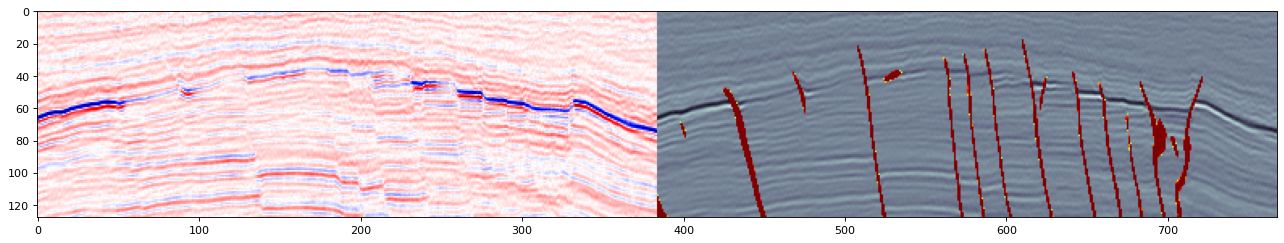

In [7]:
figure(figsize=(20, 13), dpi=80)
plt.imshow(iline)
plt.imshow(xline)